Author: Hari Kumar<br>
Created Date: 10/17/2022

*These Project helps in detectin of pothholes or anomoulies in the road.Through the machine learning image classification.

Approach

In india there are serveral accidents due to pothholes and road anomolies.These difficult to Report about the potholes or assess it without a manual survey.So to solve these issue we will be training a model that detects cracks and potholes on the roads.
The images collected are by using drones and also can be sent by people to a server with location specification so as to.The Large scale images are reduced and processed accordingly using image Features.

There will be two main data sets.One is Pothole and other is not_pothole.We will introduce the non_pothole and pothole images as 85 %training dataset and later we will use rest 15% for evaluation the model.
And Once the model is deployed the people can upload the images which will increase the Precision.

## Imports

All the Neccessary Imports.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.calibration import calibration_curve
import os, requests, zipfile
!pip install GitPython
from git import Repo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 6.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


Data Set Contains Three Directories:


1. Train/
   a. Crack
   b. non_crack
2. Test/
   a. Crack
   b.non_crack
3. Val/
   a.Crack
   b.non_crack

The downloaded dat will be stored on the in source directory. As road_cracks.

Each batch will have 32 Pics
And Photo Dimensions will be 227 * 227 Px

As of Now we will be using dataset of https://github.com/Hari-maloth/Road-Crack-Detection.git

In [2]:
batch_size = 32
photo_height = 227
photo_width = 227

filepath = 'road_cracks'
## Downloading the github repo clone 
try:
    Repo.clone_from('https://github.com/Hari-maloth/Road-Crack-Detection.git', filepath)
except:
    PRINT('Cant download neccessary resources')
    pass

#AUTOTUNE = tf.d

#train = train.cache().prefetch(buffer_size=AUTOTUNE)
#val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
#Assaining file paths.
train_path = r'{road_cracks}/dataset/train/'.format(road_cracks=filepath)
test_path = r'{road_cracks}/dataset/test'.format(road_cracks=filepath)
val_path = r'{road_cracks}/dataset/val'.format(road_cracks=filepath)


In [4]:
#Training dataset with train_path(Pre Processing).
train = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=None,
  subset=None,
  seed=42,
  image_size=(photo_height, photo_width),
  batch_size=batch_size)

Found 897 files belonging to 3 classes.


In [5]:
#Validation

val = tf.keras.preprocessing.image_dataset_from_directory(
  val_path,
  validation_split=None,
  subset=None,
  seed=42,
  image_size=(photo_height, photo_width),
  batch_size=batch_size)


Found 110 files belonging to 2 classes.


In [6]:
#Assaining Classes Names for datasets.
classes = train.class_names
print('classes: ' +str(classes))


classes: ['crack', 'no_crack', 'process']


#Preview of Data sets.

In [7]:
#Number of Pics You want Visulasize
a=int(input())
#Size of the Pic You want to Visualize
b=int(input())
if b>=32:
  print('Please Rerun this cell Also Enter B Value Below 32')

4
4


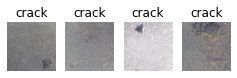

In [8]:
plt.figure(figsize=(b, b))
for images, labels in train.take(1):
  for i in range(a):
    ax = plt.subplot((a/4), 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()

In [9]:
tf.keras.backend.clear_session()

#There are two classes One is Crack Other not_Crack
num_classes = 2

#There will a preprocessing layer first it scale all the images in data set to a size of 255 px 
#After that there will be there relu activation layers
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
    
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

print('compiled!')

compiled!


Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8004

29/29 [==============================] - 43s 855ms/step - loss: 0.4588 - accuracy: 0.8004 - val_loss: 0.3402 - val_accuracy: 0.8455
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9275

29/29 [==============================] - 31s 786ms/step - loss: 0.2003 - accuracy: 0.9275 - val_loss: 0.2813 - val_accuracy: 0.9091
Epoch 3/20
29/29 [==============================] - 33s 821ms/step - loss: 0.0821 - accuracy: 0.9766 - val_loss: 0.4126 - val_accuracy: 0.8909
Epoch 4/20
29/29 [==============================] - 31s 759ms/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 0.9459 - val_accuracy: 0.8545
Epoch 5/20
29/29 [==============================] - 34s 767ms/step - loss: 0.0620 - accuracy: 0.9788 - val_loss: 0.8466 - val_accuracy: 0.8455


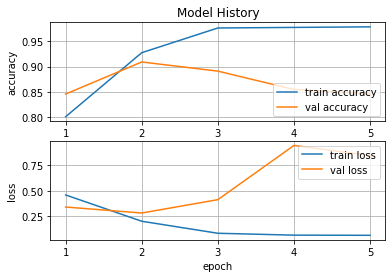

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

#We will have 20 epochs for the dataset.
history = model.fit(
  train,
  validation_data=val,
  epochs=20,
    callbacks=[model_checkpoint, early_stopping]
)


h = pd.DataFrame(history.history)
h['epoch'] = h.index + 1

#This is not necessary in the model,So as to understand and visualize the data set we will matplolib graphs.
plt.subplot(2, 1, 1)
plt.plot(h['epoch'], h['accuracy'], h['epoch'], h['val_accuracy'])
plt.title('Model History')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(('train accuracy', 'val accuracy'),
           loc='lower right')
ax1 = plt.gca()
ax1.set_xticks(range(1, max(h['epoch'])+1))


plt.subplot(2, 1, 2)
plt.plot(h['epoch'], h['loss'], h['epoch'], h['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(('train loss', 'val loss'),
           loc='upper right')
ax2 = plt.gca()
ax2.set_xticks(range(1, max(h['epoch'])+1))

plt.show()

#model.save('road_cracks')

loaded_model = tf.keras.models.load_model(filepath)

## Make Predictions

The following cell pulls all of the test photos, converts them to arrays, gets a prediction for them, and appends the results from each photo in a dataframe. You can use the import method from above as well, but it can be a bit difficult to get the results a useful format.  

In [11]:
results = pd.DataFrame(columns=['predicted', 'actual', 'probability', 'file', 'raw_logits'])

at = 0
#Giving filepaths to labels .
for label in classes: 
    path = test_path+'/'+label
    print(path)
    for file in glob.iglob(path + '/*'):
        img = keras.preprocessing.image.load_img(
        file, target_size=(photo_height, photo_width)
        )
        
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        results = results.append({'predicted': classes[np.argmax(score)], 'actual': label, 
                                  'probability': 100 * np.max(score), 'file': file,
                                 'raw_logits': score}, ignore_index=True)
        at +=1
        if at % 200 == 0:
            print(str(round(((at / 250) * 100), 1))+'%')

        

score = accuracy_score(results['actual'], results['predicted'])
print('Test Accuracy : '+str(score))

road_cracks/dataset/test/crack
1/1 [==============================] - 0s 17ms/step
road_cracks/dataset/test/no_crack
1/1 [==============================] - 0s 18ms/step
road_cracks/dataset/test/process
Test Accuracy : 0.9482758620689655


## Incorect Predictions
We have got accuarcy over 94 percent so the errors in prediction are little.But it is Necessary to Understand why did it happen.
So lets visualize the Data set of images that got Wrong prediction while the model is processing .

##Get values for incorrect predictions

In [12]:
for i in classes:
   incorrect = results.loc[(results['predicted'] == i) & (results['actual'] == i)]
   print(incorrect)

Empty DataFrame
Columns: [predicted, actual, probability, file, raw_logits]
Index: []
   predicted    actual  probability  \
26     crack  no_crack    95.562619   
48     crack  no_crack    75.419301   
50     crack  no_crack    89.127094   

                                             file  \
26   road_cracks/dataset/test/no_crack/Image5.png   
48  road_cracks/dataset/test/no_crack/Image25.png   
50  road_cracks/dataset/test/no_crack/Image29.png   

                                           raw_logits  
26  (tf.Tensor(0.9556262, shape=(), dtype=float32)...  
48  (tf.Tensor(0.754193, shape=(), dtype=float32),...  
50  (tf.Tensor(0.89127094, shape=(), dtype=float32...  
Empty DataFrame
Columns: [predicted, actual, probability, file, raw_logits]
Index: []


##Get Details For Correct Predictions

In [13]:
for i in classes:
    correct=results.loc[(results['predicted']!=1)&(results['actual']==i)]
    print(correct)

   predicted actual  probability                                        file  \
0      crack  crack    98.836201   road_cracks/dataset/test/crack/Image1.png   
1      crack  crack    98.651195  road_cracks/dataset/test/crack/Image20.png   
2      crack  crack    98.885345  road_cracks/dataset/test/crack/Image17.png   
3      crack  crack    79.970330   road_cracks/dataset/test/crack/Image5.png   
4      crack  crack    99.407649  road_cracks/dataset/test/crack/Image16.png   
5      crack  crack    98.448181  road_cracks/dataset/test/crack/Image12.png   
6      crack  crack    98.668009  road_cracks/dataset/test/crack/Image14.png   
7      crack  crack    98.171508  road_cracks/dataset/test/crack/Image15.png   
8      crack  crack    98.702753  road_cracks/dataset/test/crack/Image19.png   
9      crack  crack    97.068316  road_cracks/dataset/test/crack/Image10.png   
10     crack  crack    95.953554   road_cracks/dataset/test/crack/Image6.png   
11     crack  crack    97.133857   road_

We can see that non clear and blur images got less probability of cracks mostly. And also when image disturbance is Big.

Lets Take a look probability distribution for incorrect classifications

We will Use Pandas to Understand the errors in the model.

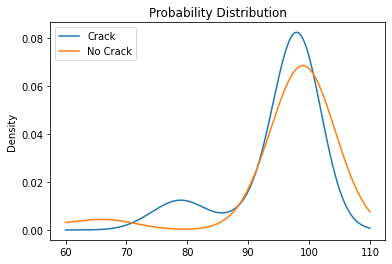

In [14]:
crack = results.loc[(results['predicted'] == 'crack')]
no_crack = results.loc[(results['predicted'] == 'no_crack')]
probs = pd.DataFrame({'Crack': crack['probability'], 'No Crack': no_crack['probability']})

ax = probs.plot.kde(ind=[i for i in np.linspace(start = 60, stop = 110, num = 1000)], 
                    title='Probability Distribution', xlabel='Probability')

We can see model is more accurate for most images for crack.

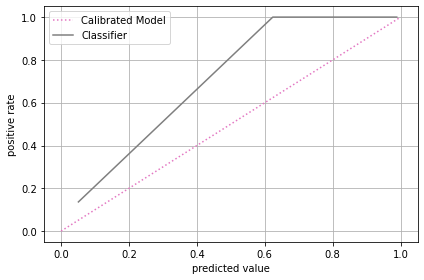

In [15]:
prob_no_crack = []
for i in range(len(results)):
    logits = results['raw_logits'][i]
    prob_no_crack.append(logits[1])

prob_true_binary, prob_pred_binary = calibration_curve(
        results['actual'].map({'crack': 0, 'no_crack': 1}), 
        prob_no_crack, n_bins=4, normalize=False)

#We will use matplotlib to visualize the graph.
fig = plt.figure()
ax = plt.gca()

plt.plot([0, 1], [0, 1], color='tab:pink', linestyle=":", label="Calibrated Model")
plt.plot(prob_pred_binary, prob_true_binary, label='Classifier', color="tab:grey")

plt.ylabel('positive rate')
plt.xlabel('predicted value')

plt.legend()
plt.yticks()
plt.grid(True)
plt.tight_layout()

plt.show()

Calibrated model performs better than classifier model.And its variance between variable is 1.Which means it is good.

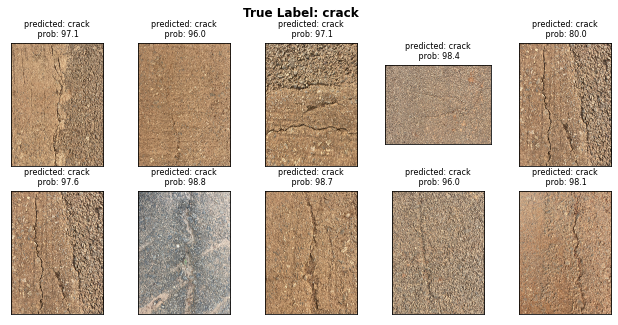

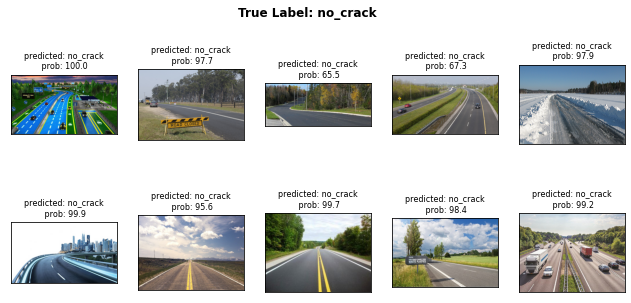

<Figure size 792x360 with 0 Axes>

In [18]:
for i in classes:
   mistakes = results.loc[(results['predicted'] == i) & (results['actual'] == i)]
   files = mistakes['file'].tail(10).values
   fig,ax = plt.subplots(2,int(len(files) / 2) + (int(len(files) % 2 > 0)))
   fig.set_size_inches(11, 5)
   prob = mistakes['probability'].tail(10).values
   act = mistakes['actual'].tail(10).values
   pred = mistakes['predicted'].tail(10).values
   fig.suptitle('True Label: '+str(i) + '\n' + ' ', weight='bold')
   
   for i in range(0, len(files)):
       with open(files[i],'rb') as f:
           image=Image.open(f)
           ax[i%2][i//2].imshow(image)
   ax_list = fig.axes
   for ax in range(len(files)):

      ax_list[ax].set_title('predicted: '+pred[ax]+ "\n" + ' prob: '+str(round(prob[ax], 1)), fontsize=8)
   for ax in range(len(ax_list)):
      ax_list[ax].set_xticks([])
      ax_list[ax].set_yticks([])
   
plt.show()

This Last line will remove downloaded data so Please Enter after all the evaluations are done

In [16]:
# delete all files downloaded in this notebook
import datetime
from git import rmtree
print('Type Yes or Y or y or yes to delete the downloaded resources')
user=input()
if user=="Yes" or user=='yes' or user=='y' or user=="Y":
  print('The downloaded resource files are deleted.Deletion intiated at '+str(datetime.datetime.now())+" UTC Time     Thank You for Presence.")
  rmtree('./'+filepath)
  print('The downloaded resource files are deleted.At '+str(time())+"Thank You for Presence.")
else:
    print("Waiting for input to Delete.If you want to delete the downloaded resources input y or Yes or yes or Y")



Type Yes or Y or y or yes to delete the downloaded resources
lk
Waiting for input to Delete.If you want to delete the downloaded resources input y or Yes or yes or Y


#Arguments


The model Generated will help classifing cracks with no cracks.Similar model can introduced for pothole and no pothole as well.There are several limations with computer vision problem such as image should be clear and model should be trained with clear images.